### Solving a Stokes equation on domains with different obstacles
We are give a domain $\Omega_\chi \subset \R^2$ which is defined as all points $x \in (0, 1)^2$ such that $\chi(x) = 1$. We will mainly consider random placed circles cut out from the domain $(0, 1)^2$. Our goal is to solve the following Stokes
equation on $\Omega_\chi$:
\begin{align*}
    -\mu \Delta u - \nabla p &= 0 &&\text{ in } \Omega_\chi, \\
    \nabla \cdot u &= 0 &&\text{ in } \Omega_\chi.
\end{align*}
With the boundary conditions:
\begin{align*}
    u &= u_{in} &&\text{ when } x_1 = 0, \\
    (\mu \nabla u + p) \cdot n &= 0 &&\text{ when } x_1 = 1, \\
    u &= 0 &&\text{ everywhere else on } \partial \Omega_\chi.
\end{align*}
Here, $u_{in}$ is a given inflow profile.

Our goal is to learn the solution operator that maps the domain $\Omega_\chi$ to the solution $u$.

This example shows the workflow in TorchPhysics for such a 2D problem. We will not get highly accurate results because we are working with a small dataset. This is done to keep the size of the GitHub repository small.
Better results can be obtained with more data.

The general procedure is the same as for the diffusion equation, so not many comments will be given.

In [ ]:
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [11]:
input_data = torch.tensor(np.load("datasets/stokes_input.npy"), dtype=torch.float32)
output_data = torch.tensor(np.load("datasets/stokes_output.npy"), dtype=torch.float32)

loc_data = torch.zeros_like(output_data)
for i in range(loc_data.shape[1]):
    for j in range(loc_data.shape[2]):
        loc_data[:, j, i, 0] = i / loc_data.shape[1]
        loc_data[:, j, i, 1] = j / loc_data.shape[2]

input_data = torch.concatenate((input_data, loc_data), dim=-1)

train_batch_size = 3500
train_input = input_data[:train_batch_size]
train_output = output_data[:train_batch_size]


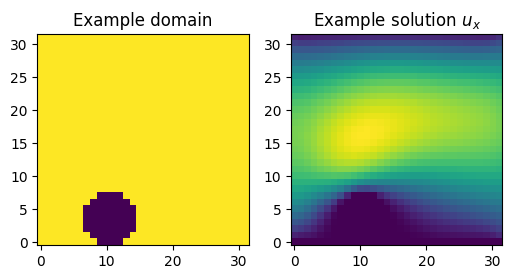

In [12]:
# Plot one example of the data
f, axarr = plt.subplots(1,2, figsize=(6, 10))
plot_idx = 12
axarr[0].imshow(train_input[plot_idx, :, :, 0], origin='lower')
axarr[0].title.set_text(r"Example domain")
axarr[1].imshow(train_output[plot_idx, :, :, 0], origin='lower')
axarr[1].title.set_text(r"Example solution $u_x$")

In TorchPhysics we have to define the input and output space like always:

In [13]:
X = tp.spaces.R2("x")
Phi = tp.spaces.R3("phi")
U = tp.spaces.R2("u")

In [14]:
data_functionset_input = tp.domains.DataFunctionSet(tp.spaces.FunctionSpace(X, Phi),
                                                    input_data)
data_functionset_output = tp.domains.DataFunctionSet(tp.spaces.FunctionSpace(X, U),
                                                    output_data)

functionsampler_input = tp.samplers.FunctionSamplerOrdered(1500, data_functionset_input)
# The output should be coupled to the correct input functions:
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

Next we create the network that learns the mapping:

In [15]:
### FNO
# hidden_channels = 32

# model = tp.models.FNO(Phi, U, 
#                       fourier_layers=8, 
#                       hidden_channels=hidden_channels, 
#                       fourier_modes=(12, 12), # Here two modes need to be set (one for each space direction) 
#                       skip_connections=True, 
#                       channel_down_sample_network=torch.nn.Sequential(
#                           torch.nn.Linear(hidden_channels, hidden_channels),
#                           torch.nn.Tanh(),
#                           torch.nn.Linear(hidden_channels, hidden_channels),
#                           torch.nn.Tanh(),
#                           torch.nn.Linear(hidden_channels, U.dim)
#                       ), 
#                       space_resolution=(32, 32)
#                       )

In [16]:
data_functionset_input.compute_pca(components=50)
data_functionset_output.compute_pca(components=50)

model = tp.models.PCANN_FC.from_fn_set(
    data_functionset_input, data_functionset_output, hidden=(60, 100, 200, 100, 60)
)

In [17]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

Start training:

In [18]:
lr_list = [0.005, 0.001, 0.0001]
step_list = [2000, 20000, 20000]

for i in range(len(lr_list)):
    optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=lr_list[i])
    solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

    trainer = pl.Trainer(devices=1, accelerator="gpu",
                        num_sanity_val_steps=0,
                        benchmark=True,
                        max_steps=step_list[i], 
                        logger=False, 
                        enable_checkpointing=False)

    trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 58.6 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
58.6 K    Trainable params
0         Non-trainable params
58.6 K    Total params
0.234     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/tra

Epoch 0: 100%|██████████| 2000/2000 [00:12<00:00, 165.25it/s, train/loss=0.405]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 0: 100%|██████████| 2000/2000 [00:12<00:00, 165.22it/s, train/loss=0.405]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 58.6 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
58.6 K    Trainable params
0         Non-trainable params
58.6 K    Total params
0.234     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 20000/20000 [01:45<00:00, 189.81it/s, train/loss=0.235]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 0: 100%|██████████| 20000/20000 [01:45<00:00, 189.81it/s, train/loss=0.235]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 58.6 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
58.6 K    Trainable params
0         Non-trainable params
58.6 K    Total params
0.234     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 20000/20000 [01:48<00:00, 184.65it/s, train/loss=0.225]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 0: 100%|██████████| 20000/20000 [01:48<00:00, 184.64it/s, train/loss=0.225]


One would need more data to get better results, but for this example we now evaluate and obtain:

In [19]:
test_input = input_data[train_batch_size:]
test_output = output_data[train_batch_size:]
model_output = model(tp.spaces.Points(test_input, Phi)).as_tensor

rel_error = torch.max(torch.abs(model_output - test_output)) / torch.max(test_output)

print(f"Relative error: {rel_error*100} %")

Relative error: 100.03378295898438 %


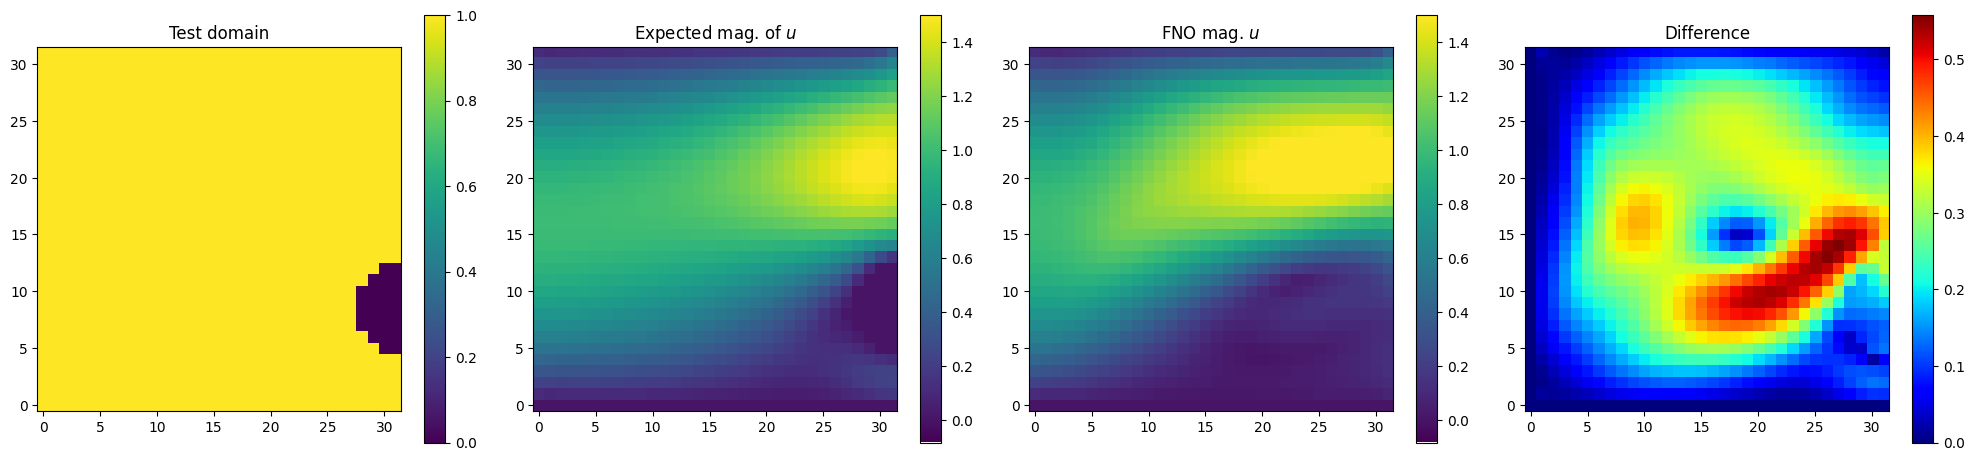

In [20]:
# Plot one example of data
plot_idx = 2 # <- value between 0 and 499

f, axarr = plt.subplots(1,4, figsize=(20, 6))
img = axarr[0].imshow(test_input[plot_idx, :, :, 0], origin='lower')
axarr[0].title.set_text(r"Test domain")
plt.colorbar(img, ax=axarr[0], shrink=0.75)

sol_min = torch.min(test_output[plot_idx])
sol_max = torch.max(test_output[plot_idx])
img = axarr[1].imshow(torch.linalg.norm(test_output[plot_idx], dim=-1), vmin=sol_min, vmax=sol_max, origin='lower')
axarr[1].title.set_text(r"Expected mag. of $u$")
plt.colorbar(img, ax=axarr[1], shrink=0.75)

img = axarr[2].imshow(torch.linalg.norm(model_output[plot_idx].detach(), dim=-1), vmin=sol_min, vmax=sol_max, origin='lower')
axarr[2].title.set_text(r"Predicted mag. of $u$")
plt.colorbar(img, ax=axarr[2], shrink=0.75)

error = torch.linalg.norm(model_output[plot_idx].detach() - test_output[plot_idx], dim=-1)
img = axarr[3].imshow(error, cmap='jet', origin='lower')
axarr[3].title.set_text(r"Difference")
plt.colorbar(img, ax=axarr[3], shrink=0.75)

plt.tight_layout()